In [1]:
import os
import sys
import gc
import pickle
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
from typing import *
from tqdm.notebook import tqdm
from pathlib import Path
from matplotlib import pyplot as plt

pd.set_option('max_columns', 50)
pd.set_option('max_rows', 200)
warnings.simplefilter('ignore')
sns.set()

In [2]:
base_dir = Path().resolve()
sys.path.append(str(base_dir / '../'))

from utils.preprocess import *
from utils.model import *
from utils.train import *
from utils.eval import *
from utils.detectron2helper import *

fail to import apex_C: apex was not installed or installed without --cpp_ext.
fail to import amp_C: apex was not installed or installed without --cpp_ext.
** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



HACKING: overriding COCOeval.summarize = vin_summarize...


In [3]:
def seed_everything(seed: int, device: str):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    with torch.cuda.device(device):
        torch.cuda.empty_cache()

In [4]:
from dataclasses import dataclass, field, asdict
import yaml


@dataclass
class Config:
    # General
    debug: bool = False
    outdir: str = "detectron2_results/retinanet_R_50_FPN_3x_mkf_5_256_rm_b30"
    device: str = "cuda:0"
    device_id: int = 0
    num_workers: int = 8

    # Data config
    imgconf_file: str = '../../data/VinBigData/train.csv'
    meta_file: str = '../../data/VinBigData/train_meta.csv'
    test_meta_file: str = '../../data/VinBigData/test_meta.csv'
    imgdir_name: str = "../../data/VinBigData/png256"
    img_size: int = 256
    seed: int = 111
    n_splits: int = 5
    iou_thr: float = 0.4
    skip_box_thr: float = 0.1
    sigma: float = 0.1
    
#     model_config: str = 'COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml'
#     model_config: str = 'COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml'
#     model_config: str = 'Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml'
#     model_config: str = 'COCO-Detection/retinanet_R_101_FPN_3x.yaml'
    model_config: str = 'COCO-Detection/retinanet_R_50_FPN_3x.yaml'
    
    # Training config
    batch_size: int = 8
    iter: int = 10000
    lr_scheduler_name: str = "WarmupCosineLR"  # WarmupMultiStepLR (default) or WarmupCosineLR
    base_lr: float = 0.00025
    roi_batch_size_per_image: int = 512
    eval_period: int = 10000
    checkpoint_period: int = 10000
        
    aug_kwargs: Dict = field(default_factory=lambda: {})
        

    def update(self, param_dict: Dict) -> "Config":
        # Overwrite by `param_dict`
        for key, value in param_dict.items():
            if not hasattr(self, key):
                raise ValueError(f"[ERROR] Unexpected key for flag = {key}")
            setattr(self, key, value)
        return self
    
    def to_yaml(self, filepath: str, width: int = 120):
        with open(filepath, 'w') as f:
            yaml.dump(asdict(self), f, width=width)

In [5]:
config_dict = {
    'debug': False,
    'batch_size': 25,
    'base_lr': 1e-3,
    'iter': 10000,
    'eval_period': 1000,
    'checkpoint_period': 1000,
    "aug_kwargs": {
        "HorizontalFlip": {"p": 0.5},
        "ShiftScaleRotate": {"scale_limit": 0.15, "rotate_limit": 10, "p": 0.5},
        "RandomBrightnessContrast": {"p": 0.5},
    },
    'iou_thr': 0.4,
    'skip_box_thr': 0.05,
}
config = Config().update(config_dict)

In [6]:
classes_nms = [
    "Aortic enlargement",
    "Atelectasis",
    "Calcification",
    "Cardiomegaly",
    "Consolidation",
    "ILD",
    "Infiltration",
    "Lung Opacity",
    "Nodule/Mass",
    "Other lesion",
    "Pleural effusion",
    "Pleural thickening",
    "Pneumothorax",
    "Pulmonary fibrosis",
#     "No Finding"
]
classes_dict = {index: class_name  for index, class_name in enumerate(classes_nms)}

In [7]:
test_meta = pd.read_csv(str(base_dir / config.test_meta_file))
# dataset_dicts_test = get_vinbigdata_dicts_test(
#     base_dir / config.imgdir_name, 
#     test_meta,
#     test_data_type=f'png{config.img_size}',
#     debug=config.debug
# )

In [8]:
DatasetCatalog.register(
    "vinbigdata_test", lambda: get_vinbigdata_dicts_test(config.imgdir_name, test_meta, debug=config.debug)
)
MetadataCatalog.get("vinbigdata_test").set(thing_classes=classes_nms)
metadata = MetadataCatalog.get("vinbigdata_test")
dataset_dicts = get_vinbigdata_dicts_test(
    base_dir / config.imgdir_name, 
    test_meta,
    test_data_type=f'png{config.img_size}',
    debug=config.debug
)

Load from cache dataset_dicts_cache_test_png256_debug0.pkl


In [10]:
torch.cuda.set_device(config.device_id)

pred_df_list = list()

for fold in range(config.n_splits):
    print(f'fold: {fold}')
    seed_everything(seed=config.seed, device=config.device)
    
    cfg = get_cfg()
    original_output_dir = cfg.OUTPUT_DIR
    cfg.OUTPUT_DIR = str(base_dir / config.outdir / f'fold-{fold + 1}')
    print(f"cfg.OUTPUT_DIR {original_output_dir} -> {cfg.OUTPUT_DIR}")

    cfg.merge_from_file(model_zoo.get_config_file(config.model_config))
    cfg.DATASETS.TRAIN = ("vinbigdata_train",)
    cfg.DATASETS.TEST = ()

    cfg.DATALOADER.NUM_WORKERS = config.num_workers
    # Let training initialize from model zoo
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config.model_config)
    cfg.SOLVER.IMS_PER_BATCH = config.batch_size
    cfg.SOLVER.BASE_LR = config.base_lr  # pick a good LR
    cfg.SOLVER.MAX_ITER = config.iter
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = config.roi_batch_size_per_image
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes_nms)
#     cfg.MODEL.ANCHOR_GENERATOR.SIZES = [[16], [32], [64], [128], [256], [512], [1024]]
#     cfg.MODEL.RPN.IN_FEATURES = ['p2', 'p2', 'p3', 'p4', 'p5', 'p6', 'p6']
#     cfg.MODEL.ANCHOR_GENERATOR.ASPECT_RATIOS = [[0.33, 0.5, 1.0, 2.0, 3.0]]

    # NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.

    ### --- Inference & Evaluation ---
    # Inference should use the config with parameters that are used in training
    # cfg now already contains everything we've set previously. We changed it a little bit for inference:
    # path to the model we just trained
    cfg.MODEL.WEIGHTS = str(base_dir / config.outdir / f'fold-{fold + 1}' / "model_final.pth")
    print("Original thresh", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)  # 0.05
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.0  # set a custom testing threshold
    print("Changed  thresh", cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST)
    predictor = DefaultPredictor(cfg)
    
    results_list = []
    index = 0
    batch_size = config.batch_size

    for i in tqdm(range(ceil(len(dataset_dicts) / batch_size))):
        inds = list(range(batch_size * i, min(batch_size * (i + 1), len(dataset_dicts))))
        dataset_dicts_batch = [dataset_dicts[i] for i in inds]
        im_list = [cv2.imread(d["file_name"]) for d in dataset_dicts_batch]
        outputs_list = predict_batch(predictor, im_list)

        for im, outputs, d in zip(im_list, outputs_list, dataset_dicts_batch):
            resized_height, resized_width, ch = im.shape
            outputs = predictor(im)
            pred_classes = outputs["instances"].to("cpu").get_fields()['pred_classes'].numpy()
            can_visualize = np.all((0 <= pred_classes) & (pred_classes <= len(classes_nms)))
            if index < 5 and can_visualize:
                # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
                v = Visualizer(
                    im[:, :, ::-1],
                    metadata=metadata,
                    scale=0.5,
                    instance_mode=ColorMode.IMAGE_BW
                    # remove the colors of unsegmented pixels. This option is only available for segmentation models
                )
                out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
                # cv2_imshow(out.get_image()[:, :, ::-1])
                cv2.imwrite(str(base_dir / config.outdir / f'fold-{fold + 1}' / f"pred_{index}.jpg"), out.get_image()[:, :, ::-1])

            image_id, dim0, dim1 = test_meta.iloc[index].values

            instances = outputs["instances"]
            if len(instances) == 0:
                # No finding, let's set 14 1 0 0 1 1x.
                result = {"image_id": image_id, "PredictionString": "14 1.0 0 0 1 1"}
            else:
                # Find some bbox...
                # print(f"index={index}, find {len(instances)} bbox.")
                fields: Dict[str, Any] = instances.get_fields()
                pred_classes = fields["pred_classes"]  # (n_boxes,)
                pred_scores = fields["scores"]
                # shape (n_boxes, 4). (xmin, ymin, xmax, ymax)
                pred_boxes = fields["pred_boxes"].tensor

                h_ratio = dim0 / resized_height
                w_ratio = dim1 / resized_width
                pred_boxes[:, [0, 2]] *= w_ratio
                pred_boxes[:, [1, 3]] *= h_ratio

                pred_classes_array = pred_classes.cpu().numpy()
                pred_boxes_array = pred_boxes.cpu().numpy()
                pred_scores_array = pred_scores.cpu().numpy()

                mask = (0 <= pred_classes_array) & (pred_classes_array < len(classes_nms))  # RetinaNet's outputs uncorrectly contain unknown class_id

                result = {
                    "image_id": image_id,
                    "PredictionString": format_pred(
                        pred_classes_array[mask], pred_boxes_array[mask], pred_scores_array[mask]
                    ),
                }
            results_list.append(result)
            index += 1
    
    pred_df_list += [pd.DataFrame(results_list, columns=['image_id', 'PredictionString'])]

Loading config /home/yamaguchi-milkcocholate/.pyenv/versions/3.7.6/envs/VinBigData/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


fold: 0
cfg.OUTPUT_DIR ./output -> /home/yamaguchi-milkcocholate/VinBigData/src/VinBigData-ObjectDetection/detectron2_results/retinanet_R_50_FPN_3x_mkf_5_256_rm_b30/fold-1
Original thresh 0.05
Changed  thresh 0.0


  0%|          | 0/120 [00:00<?, ?it/s]

Loading config /home/yamaguchi-milkcocholate/.pyenv/versions/3.7.6/envs/VinBigData/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


fold: 1
cfg.OUTPUT_DIR ./output -> /home/yamaguchi-milkcocholate/VinBigData/src/VinBigData-ObjectDetection/detectron2_results/retinanet_R_50_FPN_3x_mkf_5_256_rm_b30/fold-2
Original thresh 0.05
Changed  thresh 0.0


  0%|          | 0/120 [00:00<?, ?it/s]

Loading config /home/yamaguchi-milkcocholate/.pyenv/versions/3.7.6/envs/VinBigData/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


fold: 2
cfg.OUTPUT_DIR ./output -> /home/yamaguchi-milkcocholate/VinBigData/src/VinBigData-ObjectDetection/detectron2_results/retinanet_R_50_FPN_3x_mkf_5_256_rm_b30/fold-3
Original thresh 0.05
Changed  thresh 0.0


  0%|          | 0/120 [00:00<?, ?it/s]

Loading config /home/yamaguchi-milkcocholate/.pyenv/versions/3.7.6/envs/VinBigData/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


fold: 3
cfg.OUTPUT_DIR ./output -> /home/yamaguchi-milkcocholate/VinBigData/src/VinBigData-ObjectDetection/detectron2_results/retinanet_R_50_FPN_3x_mkf_5_256_rm_b30/fold-4
Original thresh 0.05
Changed  thresh 0.0


  0%|          | 0/120 [00:00<?, ?it/s]

Loading config /home/yamaguchi-milkcocholate/.pyenv/versions/3.7.6/envs/VinBigData/lib/python3.7/site-packages/detectron2/model_zoo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


fold: 4
cfg.OUTPUT_DIR ./output -> /home/yamaguchi-milkcocholate/VinBigData/src/VinBigData-ObjectDetection/detectron2_results/retinanet_R_50_FPN_3x_mkf_5_256_rm_b30/fold-5
Original thresh 0.05
Changed  thresh 0.0


  0%|          | 0/120 [00:00<?, ?it/s]

In [11]:
# save predictions, which isn't post processed
for fold, pred_df in enumerate(pred_df_list):
    pred_df.to_csv(str(base_dir / config.outdir / f'fold-{fold + 1}' / 'submission.csv'), index=False)

In [13]:
from typing import List, Tuple

import matplotlib.patches as patches
import numpy as np
from PIL import Image


def add_bboxes_to_image(ax, image: np.ndarray,
                        bboxes: List[Tuple[int, int, int, int]],
                        labels: List[str] = None,
                        label_size: int = 10,
                        line_width: int = 2,
                        border_color=(0, 1, 0, 1)) -> None:
    """
    Add bbox to ax

    :param image: dtype=np.uint8
    :param bbox: [(left, top, right, bottom)]
    :param label: List[str] or None
    :return: ax
    """
    # Display the image
    ax.imshow(image)

    if labels is None:
        labels = [None] * len(bboxes)

    for bbox, label in zip(bboxes, labels):
        # Add bounding box
        x_min, y_min, x_max, y_max = bbox
        rect = patches.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                 linewidth=line_width,
                                 edgecolor=border_color,
                                 facecolor='none')
        ax.add_patch(rect)

        # label
        if label:
            bbox_props = dict(boxstyle="square,pad=0",
                              linewidth=line_width, facecolor=border_color,
                              edgecolor=border_color)
            ax.text(x_min, y_min, label,
                    ha="left", va="bottom", rotation=0,
                    size=label_size, bbox=bbox_props)
    return ax


def plot_samples(dataset_dicts):
    train_dataset = VinBigDataset(dataset_dicts=dataset_dicts, transform=Transform({}, train=True))
    fig, axes = plt.subplots(1, 4, figsize=(25, 6))
    for i, ax in enumerate(axes):
        img, target, _ = train_dataset[i]
        img = img.numpy().transpose((1, 2, 0))
        add_bboxes_to_image(ax, np.uint8(img), target['boxes'], target['labels'].numpy())
        ax.axis("off")
    plt.show()

In [40]:
# i = 0
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))


# img = cv2.imread(dataset_dicts[i]['file_name'])
# image_id, width, height = test_meta.values[i]
# assert image_id == dataset_dicts[i]['image_id']
# img = cv2.resize(img, (width, height))
# pred = np.array(pred_df.loc[i, 'PredictionString'].split(' ')).reshape(-1, 6)

# boxes = pred[:, 2:].astype(float)
# labels = pred[:, 0].astype(int)
# scores = pred[:, 1].astype(float)

# mask = (scores > 0.3)

# add_bboxes_to_image(ax, np.uint8(img), boxes[mask, :], labels[mask])
# ax.axis("off")

# plt.show()

In [11]:
pred_df_list = [pd.read_csv(base_dir / config.outdir / f'fold-{fold + 1}' / 'submission.csv') for fold in range(config.n_splits)]

In [12]:
def nms_by_class(
    boxes: np.ndarray, scores: np.ndarray, labels: np.ndarray, 
    cls_id: int, iou_thr: float, skip_box_thr: float, sigma: float
) -> Tuple[List[List[float]], List[float], List[int]]:
    mask = (labels == cls_id)
    if mask.sum() == 1:
        return boxes[mask, :], scores[mask], labels[mask]
    else:
        return nms(
            [boxes[mask, :].tolist()],
            [scores[mask].tolist()],
            [labels[mask].tolist()],
            weights=None, 
            iou_thr=iou_thr,
        )

In [13]:
# post process using soft-NMS for each fold
from ensemble_boxes import *

iou_threshes = {
    "Aortic enlargement": 0.4,
    "Atelectasis": 0.4,
    "Calcification": 0.1,
    "Cardiomegaly": 0.4,
    "Consolidation": 0.4,
    "ILD": 0.4,
    "Infiltration": 0.4,
    "Lung Opacity": 0.4,
    "Nodule/Mass": 0.4,
    "Other lesion": 0.4,
    "Pleural effusion": 0.4,
    "Pleural thickening": 0.0001,
    "Pneumothorax": 0.4,
    "Pulmonary fibrosis": 0.4,
}

for pred_df in pred_df_list:
    
    for i, (image_id, height, width) in tqdm(enumerate(test_meta.values)):
        f_image_id, f_pred_str = pred_df.values[i]
        assert image_id == f_image_id
        
        boxes, scores, labels = list(), list(), list()
        
        objs = np.array(f_pred_str.split(' ')).reshape(-1, 6)
        f_boxes = objs[:, 2:].astype(float)
        f_boxes[:, [0, 2]] /= width
        f_boxes[:, [1, 3]] /= height
        f_labels = objs[:, 0].astype(int)
        f_scores = objs[:, 1].astype(float)
        
        for class_id in range(len(classes_nms)):
            if (f_labels == class_id).sum() == 0:
                continue
            c_boxes, c_scores, c_labels = nms_by_class(
                boxes=f_boxes,
                scores=f_scores,
                labels=f_labels,
                cls_id=class_id,
                iou_thr=list(iou_threshes.values())[class_id],
                skip_box_thr=config.skip_box_thr,
                sigma=config.sigma,
            )

            c_boxes = np.array(c_boxes)
            c_boxes[:, [0, 2]] *= width
            c_boxes[:, [1, 3]] *= height

            boxes += c_boxes.tolist()
            scores += c_scores.tolist()
            labels += c_labels.tolist()
        
        pred_str = list()
        for label, score, box in zip(labels, scores, boxes):
            pred_str += [str(int(label))] + [str(score)] + np.array(box).astype(str).tolist()
    
        pred_df.loc[i, 'PredictionString'] = ' '.join(pred_str)

0it [00:00, ?it/s]

In [14]:
# save predictions, which is post processed by NMS
for fold, pred_df in enumerate(pred_df_list):
    pred_df.to_csv(str(base_dir / config.outdir / f'fold-{fold + 1}' / 'submission_nms.csv'), index=False)

In [15]:
pred_df_list = [pd.read_csv(base_dir / config.outdir / f'fold-{fold + 1}' / 'submission_nms.csv') for fold in range(config.n_splits)]

In [31]:
# remove instances with low score
THRESHOLD = 0.25
MIN_NUM_PREDS = 5

for pred_df in tqdm(pred_df_list):
    for i in range(len(pred_df)):
        objs = np.array(pred_df.loc[i, 'PredictionString'].split(' ')).reshape(-1, 6)
        objs = sorted(objs, key=lambda x: -float(x[1]))
        
        if float(objs[MIN_NUM_PREDS][1]) < THRESHOLD:
            remains = objs[:5]
        else:
            remains = [obj for obj in objs if float(obj[1]) > THRESHOLD]
        pred_str = list()
        
        for remain in remains:
            pred_str += [remain[0]] + [remain[1]] + remain[2:].tolist()
                
        pred_df.loc[i, 'PredictionString'] = ' '.join(pred_str)

  0%|          | 0/5 [00:00<?, ?it/s]

In [32]:
# save predictions, which is post processed by NMS
for fold, pred_df in enumerate(pred_df_list):
    pred_df.to_csv(str(base_dir / config.outdir / f'fold-{fold + 1}' / 'submission_nms_thr.csv'), index=False)

In [43]:
pred_df_list = [pd.read_csv(base_dir / config.outdir / f'fold-{fold + 1}' / 'submission_nms_thr.csv') for fold in range(config.n_splits)]

In [16]:
# ensemble all fold's predictions

records = {'image_id': list(), 'PredictionString': list()}

for i, (image_id, height, width) in tqdm(enumerate(test_meta.values)):  
    e_labels = list()
    e_scores = list()
    e_boxes = list()
    
    for fold, pred_df in enumerate(pred_df_list):
        f_image_id, f_pred_str = pred_df.values[i]
        assert image_id == f_image_id
        
        objs = np.array(f_pred_str.split(' ')).reshape(-1, 6)
        f_boxes = objs[:, 2:].astype(float)
        f_boxes[:, [0, 2]] /= width
        f_boxes[:, [1, 3]] /= height
        
        e_labels += objs[:, 0].astype(int).tolist()
        e_scores += objs[:, 1].astype(float).tolist()
        e_boxes += f_boxes.tolist()
    
    boxes, scores, labels = weighted_boxes_fusion([e_boxes], [e_scores], [e_labels], weights=None, iou_thr=config.iou_thr, skip_box_thr=config.skip_box_thr)
    
    boxes = np.array(boxes)
    boxes[:, [0, 2]] *= width
    boxes[:, [1, 3]] *= height
    
    e_pred_str = list()
    for label, score, box in zip(labels, scores, boxes):
        e_pred_str += [str(int(label))] + [str(score)] + box.astype(str).tolist()
    
    records['image_id'] += [image_id]
    records['PredictionString'] += [' '.join(e_pred_str)]
    
ensemble_df = pd.DataFrame(records)

0it [00:00, ?it/s]

In [17]:
pred_0246_df = pd.read_csv(base_dir / '0246_copy_submission_postprocessed.csv')
pred_0246_df

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,14 1 0 0 1 1
1,004f33259ee4aef671c2b95d54e4be68,11 0.097 1406 302 1701 367 0 0.838 1254 585 15...
2,008bdde2af2462e86fd373a445d0f4cd,13 0.009 734 1097 833 1198 11 0.05 1589 439 18...
3,009bc039326338823ca3aa84381f17f1,14 1 0 0 1 1
4,00a2145de1886cb9eb88869c85d74080,13 0.064 555 1289 809 1406 3 0.854 776 1270 18...
...,...,...
2995,ff91fb82429a27521bbec8569b041f02,13 0.385 2334 1212 2412 1302 13 0.014 858 1344...
2996,ff9fcc4087ed5e941209aa3fa948e364,11 0.075 1296 383 1503 456 7 0.023 819 742 101...
2997,ffaa288c8abca300974f043b57d81521,14 1 0 0 1 1
2998,ffc441e0c8b7153844047483a577e7c3,0 0.248 983 646 1230 932 14 0 0 0 1 1


In [46]:
submission = pd.merge(pred_0246_df, ensemble_df, how='left', on='image_id')
submission = pd.merge(submission, test_meta, how='left', on='image_id')
submission

,image_id,PredictionString_x,PredictionString_y,dim0,dim1
0,002a34c58c5b758217ed1f584ccbcfe9,14 1 0 0 1 1,3 0.45567163825035095 832.916237860918 1239.87...,2584,2345
1,004f33259ee4aef671c2b95d54e4be68,11 0.097 1406 302 1701 367 0 0.838 1254 585 15...,0 0.7147951126098633 1258.5649607777596 581.17...,3028,2517
2,008bdde2af2462e86fd373a445d0f4cd,13 0.009 734 1097 833 1198 11 0.05 1589 439 18...,0 0.7219107151031494 1434.7842407226562 817.23...,2880,2304
3,009bc039326338823ca3aa84381f17f1,14 1 0 0 1 1,3 0.64862305 667.86584 1044.4628 1559.1077 134...,2430,1994
4,00a2145de1886cb9eb88869c85d74080,13 0.064 555 1289 809 1406 3 0.854 776 1270 18...,3 0.68199414 781.6629 1286.36 1853.743 1638.14...,2408,2136
...,...,...,...,...,...
2995,ff91fb82429a27521bbec8569b041f02,13 0.385 2334 1212 2412 1302 13 0.014 858 1344...,0 0.7568007707595825 1614.6069946289062 621.57...,3072,3072
2996,ff9fcc4087ed5e941209aa3fa948e364,11 0.075 1296 383 1503 456 7 0.023 819 742 101...,0 0.6967495679855347 1140.2225875854492 692.80...,2880,2304
2997,ffaa288c8abca300974f043b57d81521,14 1 0 0 1 1,10 0.591392457485199 1895.0778176784515 1572.7...,2958,2684
2998,ffc441e0c8b7153844047483a577e7c3,0 0.248 983 646 1230 932 14 0 0 0 1 1,3 0.48256078362464905 748.0262625217438 1256.8...,2328,1944


In [47]:
NORMAL = '14 1 0 0 1 1'
SCORE_THRESH = 0.05
records = {'image_id': list(), 'PredictionString': list()}
submission['PredictionString'] = ''

for i, (image_id, kernel, my, height, width) in tqdm(enumerate(submission.values[:, :-1])):
    if kernel == NORMAL:
        submission.loc[i, 'PredictionString'] = NORMAL
        continue
        
    e_labels = list()
    e_scores = list()
    e_boxes = list()
    
    k_objs = np.array(kernel.split(' ')).reshape(-1, 6)
    k_boxes = k_objs[:, 2:].astype(float)
    k_boxes[:, [0, 2]] /= width
    k_boxes[:, [1, 3]] /= height

    k_labels = k_objs[:, 0].astype(int).tolist()
    k_scores = k_objs[:, 1].astype(float).tolist()
    k_boxes = k_boxes.tolist()
    
    m_objs = np.array(my.split(' ')).reshape(-1, 6)
    m_boxes = m_objs[:, 2:].astype(float)
    m_boxes[:, [0, 2]] /= width
    m_boxes[:, [1, 3]] /= height

    m_labels = m_objs[:, 0].astype(int).tolist()
    m_scores = m_objs[:, 1].astype(float).tolist()
    m_boxes = m_boxes.tolist()
    
    boxes, scores, labels = weighted_boxes_fusion([k_boxes, m_boxes], [k_scores, m_scores], [k_labels, m_labels], weights=[1.5, 1], iou_thr=config.iou_thr, skip_box_thr=config.skip_box_thr)
    
    boxes = np.array(boxes)
    boxes[:, [0, 2]] *= width
    boxes[:, [1, 3]] *= height
    
    e_pred_str = list()
    for label, score, box in zip(labels, scores, boxes):
        if score > SCORE_THRESH:
            e_pred_str += [str(int(label))] + [str(score)] + box.astype(int).astype(str).tolist()
    
    submission.loc[i, 'PredictionString'] = ' '.join(e_pred_str)

0it [00:00, ?it/s]

In [18]:
pred_2class_df = pd.read_csv(base_dir / '0246_2-cls_test_pred.csv')
pred_2class_df

,image_id,target
0,002a34c58c5b758217ed1f584ccbcfe9,0.013326
1,004f33259ee4aef671c2b95d54e4be68,0.037235
2,008bdde2af2462e86fd373a445d0f4cd,0.939700
3,009bc039326338823ca3aa84381f17f1,0.123799
4,00a2145de1886cb9eb88869c85d74080,0.654006
...,...,...
2995,ff91fb82429a27521bbec8569b041f02,0.936325
2996,ff9fcc4087ed5e941209aa3fa948e364,0.963583
2997,ffaa288c8abca300974f043b57d81521,0.178720
2998,ffc441e0c8b7153844047483a577e7c3,0.225196


In [49]:
# submission_2class = pd.read_csv(str(base_dir / 'pfn_copy_test_pred.csv'))
# submission_2class

In [19]:
# submission = pd.merge(submission, pred_2class_df, how='left', on='image_id')
# submission

submission = pd.merge(ensemble_df, pred_2class_df, how='left', on='image_id')
submission

,image_id,PredictionString,target
0,8dec5497ecc246766acfba5a4be4e619,0 0.2501046061515808 1037.0 595.0 1252.0 878.0...,0.010527
1,287422bed1d9d153387361889619abed,3 0.5412694215774536 673.0000000000001 1142.0 ...,0.686638
2,1d12b94b7acbeadef7d7700b50aa90d4,0 0.522853434085846 1170.0 884.9999999999999 1...,0.006848
3,6b872791e23742f6c33a08fc24f77365,5 0.2051709145307541 1455.0 1406.0 1902.0 2144...,0.043275
4,d0d2addff91ad7beb1d92126ff74d621,3 0.44704851508140564 1117.0 1481.0 2102.0 189...,0.013268
...,...,...,...
2995,78b44b96b121d6075d7ae27135278e03,3 0.2045578807592392 754.0 1345.0 1481.0 1717....,0.013812
2996,afee8ff90f29b8827d0eb78774d25324,0 0.3264782428741455 1046.0 698.0 1251.0 973.9...,0.012585
2997,6e07fab2014be723250f7897ab6e3df2,0 0.3811582922935486 1499.0 793.0 1965.0 1211....,0.047763
2998,690bb572300ef08bbbb7ebf4196099cf,0 0.26047706604003906 1113.0 678.0 1345.0 976....,0.020076


In [20]:
low_threshold = 0.001
high_threshold = 0.87

c0, c1, c2 = 0, 0, 0

for i in tqdm(submission.index):
    p0 = 1 - submission.loc[i, 'target']
    
    if p0 < low_threshold:
        c0 += 1
        pass
    elif low_threshold <= p0 and p0 < high_threshold:
        c1 += 1
        submission.loc[i, 'PredictionString'] += f" 14 0 0 0 1 1"
    else:
        c2 += 1
        submission.loc[i, 'PredictionString'] = '14 1 0 0 1 1'
        
print(f"Keep {c0} Add {c1} Replace {c2}")

  0%|          | 0/3000 [00:00<?, ?it/s]

Keep 0 Add 937 Replace 2063


In [21]:
submission = submission[['image_id', 'PredictionString']]
submission.to_csv(str(base_dir / 'submission.csv'), index=False)
submission

,image_id,PredictionString
0,8dec5497ecc246766acfba5a4be4e619,14 1 0 0 1 1
1,287422bed1d9d153387361889619abed,3 0.5412694215774536 673.0000000000001 1142.0 ...
2,1d12b94b7acbeadef7d7700b50aa90d4,14 1 0 0 1 1
3,6b872791e23742f6c33a08fc24f77365,14 1 0 0 1 1
4,d0d2addff91ad7beb1d92126ff74d621,14 1 0 0 1 1
...,...,...
2995,78b44b96b121d6075d7ae27135278e03,14 1 0 0 1 1
2996,afee8ff90f29b8827d0eb78774d25324,14 1 0 0 1 1
2997,6e07fab2014be723250f7897ab6e3df2,14 1 0 0 1 1
2998,690bb572300ef08bbbb7ebf4196099cf,14 1 0 0 1 1


In [226]:
pred_by_class = [list() for i in range(len(classes_nms) + 1)]
for obj in np.array(' '.join(submission.values[:, 1].tolist()).split(' ')).reshape(-1, 6):
    try:
        pred_by_class[int(obj[0])] += [float(obj[1])]
    except IndexError as e:
        print(obj)
        raise e

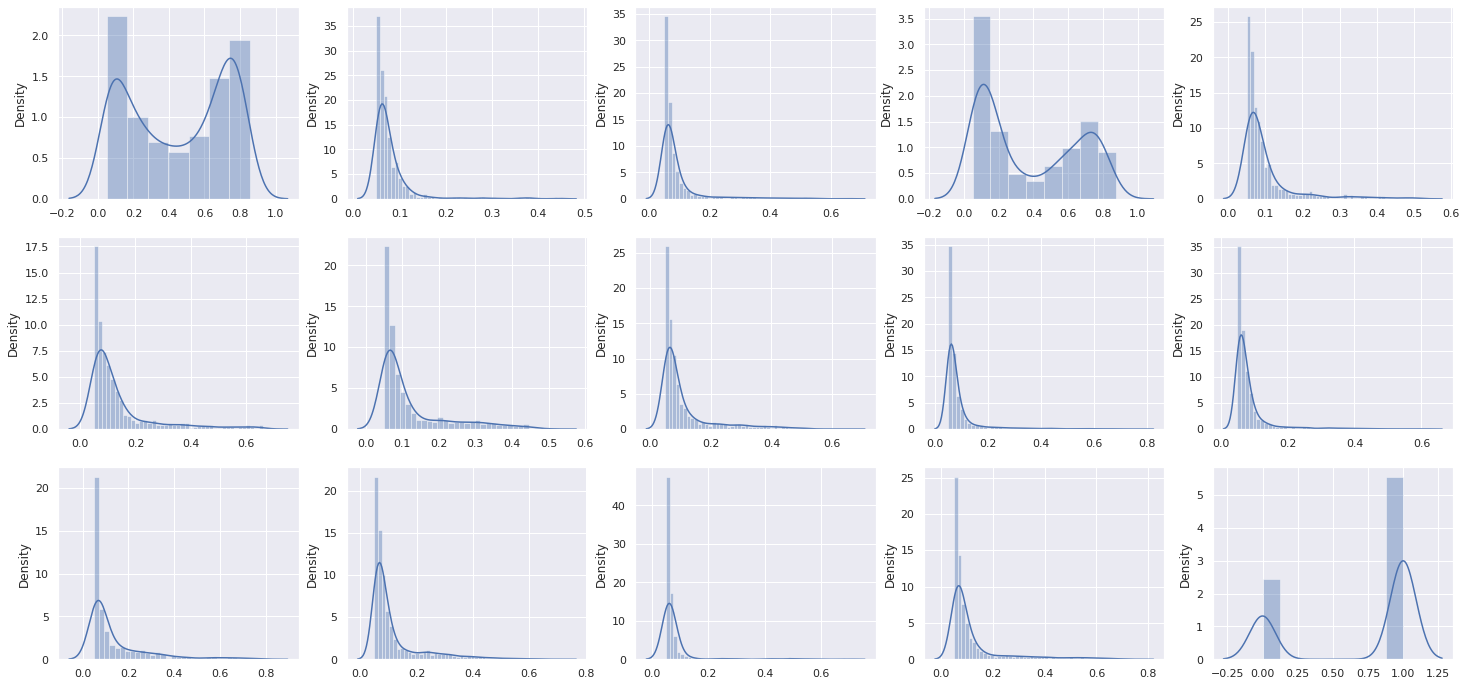

In [228]:
fig, axes = plt.subplots(3, 5, figsize=(25, 12))
for i in range(len(pred_by_class)):
    sns.distplot(pred_by_class[i], ax=axes[i // 5][i % 5])
plt.show()

In [230]:
pred_by_class = [list() for i in range(len(classes_nms) + 1)]
for obj in np.array(' '.join(pred_0246_df.values[:, 1].tolist()).split(' ')).reshape(-1, 6):
    try:
        pred_by_class[int(obj[0])] += [float(obj[1])]
    except IndexError as e:
        print(obj)
        raise e

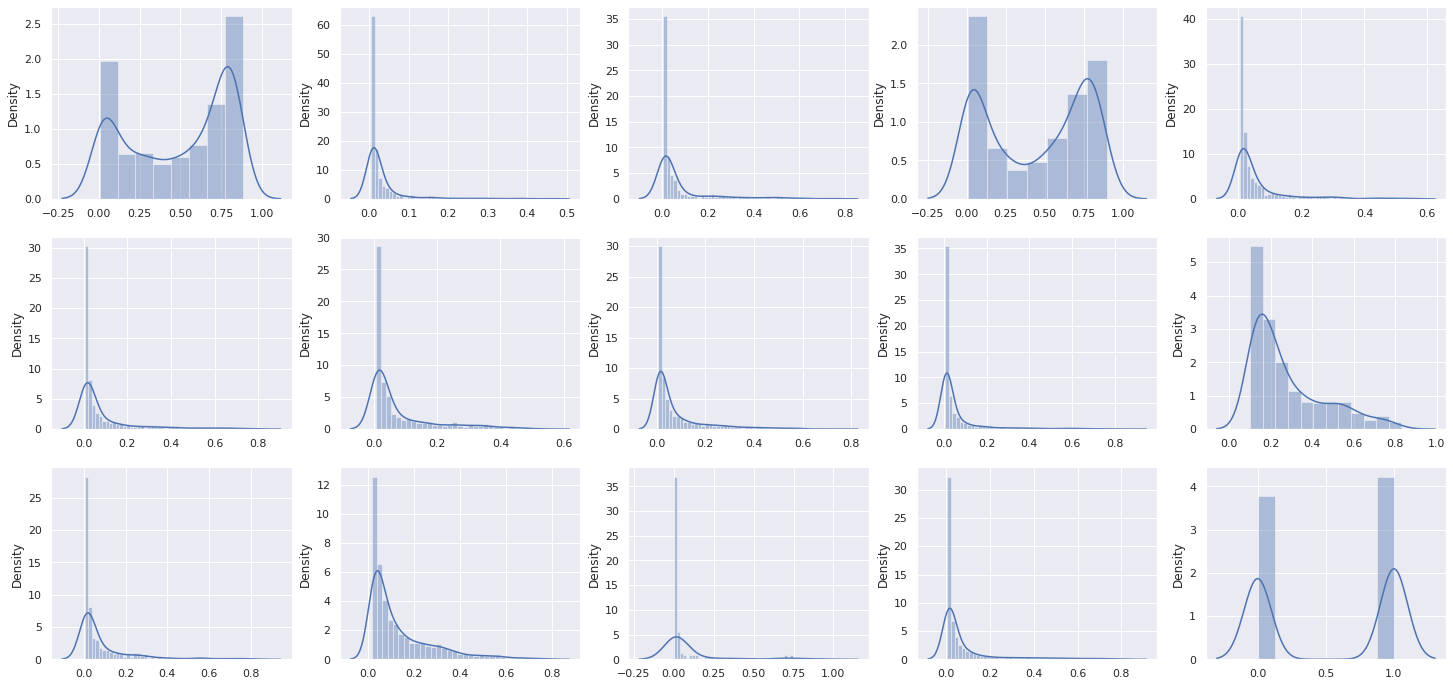

In [231]:
fig, axes = plt.subplots(3, 5, figsize=(25, 12))
for i in range(len(pred_by_class)):
    sns.distplot(pred_by_class[i], ax=axes[i // 5][i % 5])
plt.show()